In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from matplotlib.image import imread
from scipy.optimize import minimize
from skimage.transform import resize

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

mustache = imread(os.path.join('..', 'datasets', 'mustache.jpg'))
mustache = np.mean(mustache, -1);  # Convert RGB to grayscale
mustache = (mustache / 255).astype(int)
mustache = mustache.T

mat = scipy.io.loadmat(os.path.join('..', 'datasets', 'allFaces.mat'))
X = mat['faces']
nfaces = mat['nfaces'].reshape(-1)
n = mat['n']
n = int(n)
m = mat['m']
m = int(m)

In [2]:
## Build Training and Test sets
nTrain = 30
nTest = 20
nPeople = 20
Train = np.zeros((X.shape[0], nTrain * nPeople))
Test = np.zeros((X.shape[0], nTest * nPeople))

for k in range(nPeople):
    baseind = 0
    if k > 0:
        baseind = np.sum(nfaces[:k])
    inds = range(baseind, baseind + nfaces[k])
    Train[:, k * nTrain:(k + 1) * nTrain] = X[:, inds[:nTrain]]
    Test[:, k * nTest:(k + 1) * nTest] = X[:, inds[nTrain:(nTrain + nTest)]]

In [6]:
M = Train.shape[1]

Theta = np.zeros((120, M))
for k in range(M):
    temp = np.reshape(np.copy(Train[:, k]), (m, n))
    tempSmall = resize(temp, (10, 12), anti_aliasing=True)
    Theta[:, k] = np.reshape(tempSmall, 120, "A")

In [7]:
## Renormalize Columns of Theta
normTheta = np.zeros(M)
for k in range(M):
    normTheta[k] = np.linalg.norm(Theta[:, k])
    Theta[:, k] = Theta[:, k] / normTheta[k]

In [8]:
## Occlude Test Image (Test[:,125] = test image 6, person 7)
x1 = np.copy(Test[:,125]) # Clean image
x2 = np.copy(Test[:,125]) * mustache.reshape(n*m)
randvec = np.random.permutation(n*m)
first30 = randvec[:int(np.floor(0.3*len(randvec)))]
vals30 = (255*np.random.rand(*first30.shape)).astype(int)
x3 = np.copy(x1)
x3[first30] = vals30 # 30% occluded
x4 = np.copy(x1) + 50*np.random.randn(*x1.shape) # Random noise

In [10]:
## Downsample Test Images
X = np.zeros((x1.shape[0], 4))
X[:, 0] = x1
X[:, 1] = x2
X[:, 2] = x3
X[:, 3] = x4

Y = np.zeros((120, 4))
for k in range(4):
    temp = np.reshape(np.copy(X[:, k]), (m, n))
    tempSmall = resize(temp, (10, 12), anti_aliasing=True)
    Y[:, k] = np.reshape(tempSmall, 120, "A")

In [11]:
## L1 Search, Testclean
y1 = np.copy(Y[:, 0])
eps = 0.01


# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x, ord=1)


constr = ({'type': 'ineq', 'fun': lambda x: eps - np.linalg.norm(Theta @ x - y1, 2)})
x0 = np.linalg.pinv(Theta) @ y1  # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
s1 = res.x

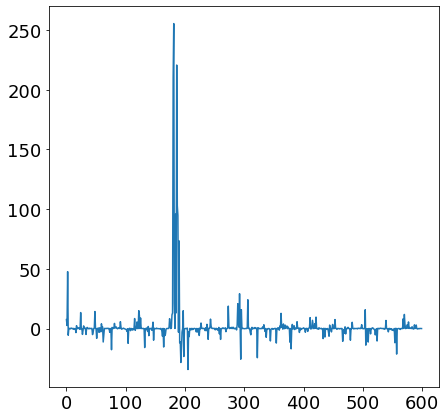

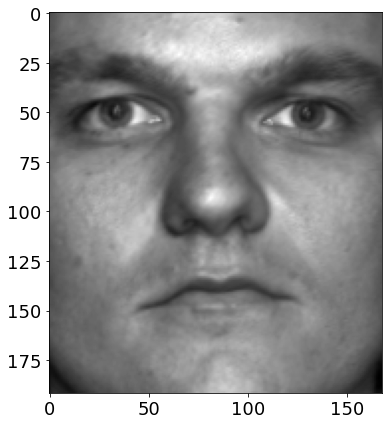

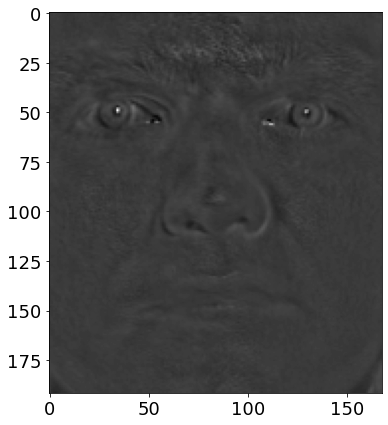

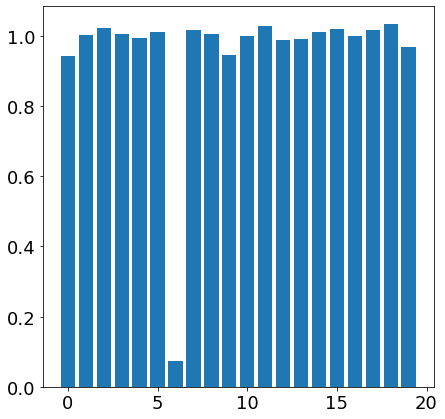

In [13]:
plt.figure()
plt.plot(s1)
plt.figure()
plt.imshow(np.reshape(Train @ (s1 / normTheta), (m, n)).T, cmap='gray')
plt.figure()
plt.imshow(np.reshape(x1 - Train @ (s1 / normTheta), (m, n)).T, cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k * nTrain, (k + 1) * nTrain)
    binErr[k] = np.linalg.norm(x1 - Train[:, L] @ (s1[L] / normTheta[L])) / np.linalg.norm(x1)

plt.figure()
plt.bar(range(nPeople), binErr)
plt.show()


In [14]:
## L1 Search, Mustache
y2 = np.copy(Y[:, 1])
eps = 500


# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x, ord=1)


constr = ({'type': 'ineq', 'fun': lambda x: eps - np.linalg.norm(Theta @ x - y2, 2)})
x0 = np.linalg.pinv(Theta) @ y2  # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
s2 = res.x

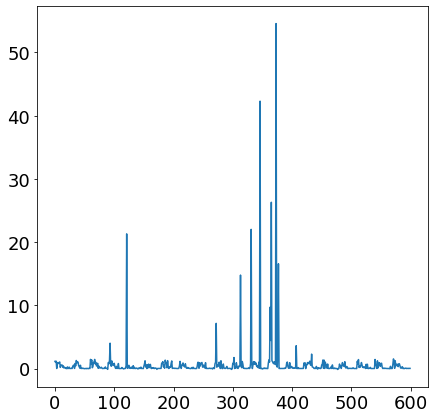

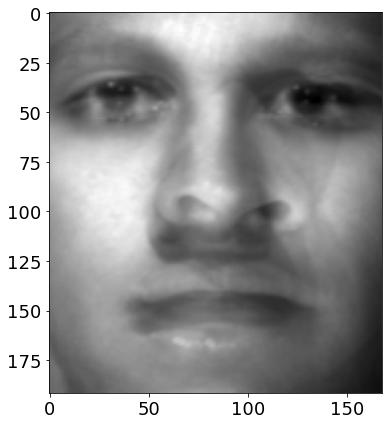

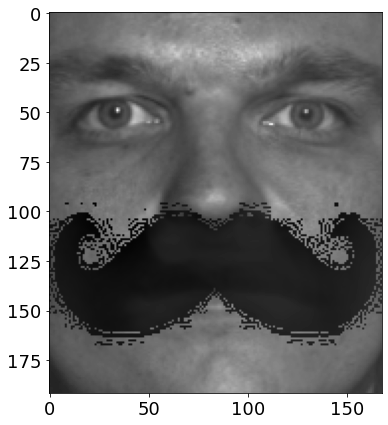

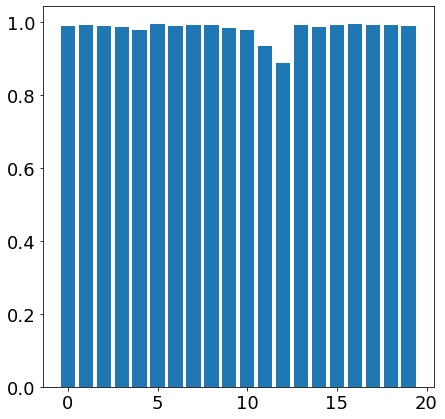

In [15]:
plt.figure()
plt.plot(s2)
plt.figure()
plt.imshow(np.reshape(Train @ (s2 / normTheta), (m, n)).T, cmap='gray')
plt.figure()
plt.imshow(np.reshape(x2 - Train @ (s2 / normTheta), (m, n)).T, cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k * nTrain, (k + 1) * nTrain)
    binErr[k] = np.linalg.norm(x2 - Train[:, L] @ (s2[L] / normTheta[L])) / np.linalg.norm(x2)

plt.figure()
plt.bar(range(nPeople), binErr)
plt.show()

In [16]:
## L1 Search, Occlusion
y3 = np.copy(Y[:, 2])
eps = 1000


# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x, ord=1)


constr = ({'type': 'ineq', 'fun': lambda x: eps - np.linalg.norm(Theta @ x - y3, 2)})
x0 = np.linalg.pinv(Theta) @ y3  # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
s3 = res.x

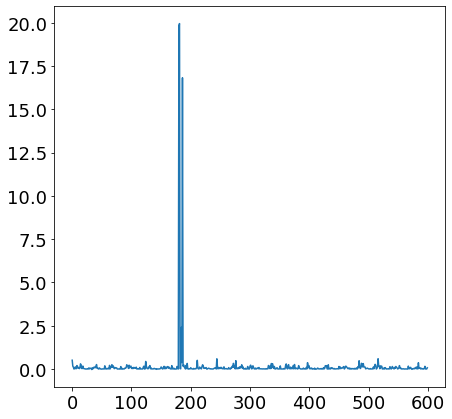

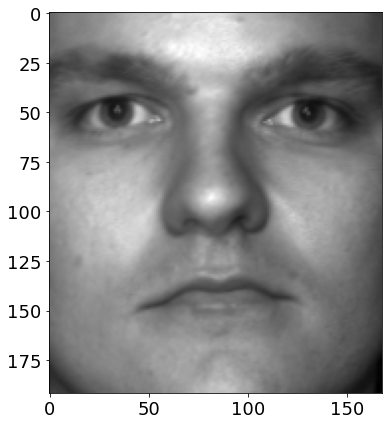

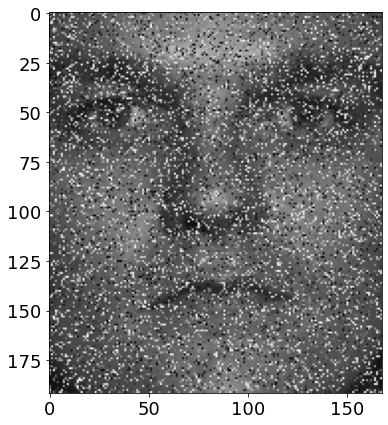

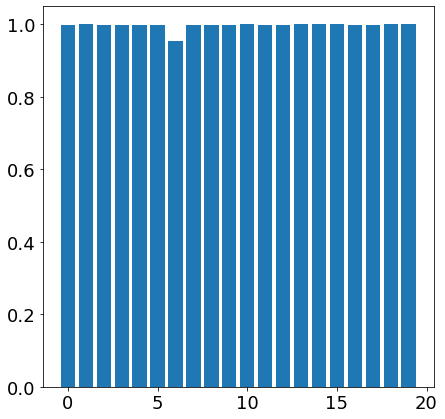

In [17]:
plt.figure()
plt.plot(s3)
plt.figure()
plt.imshow(np.reshape(Train @ (s3/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x3 - Train @ (s3/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x3-Train[:,L] @ (s3[L]/normTheta[L]))/np.linalg.norm(x3)
    
plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

In [19]:
## L1 Search, Noise
y4 = np.copy(Y[:,3])
eps = 10

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y4,2)})
x0 = np.linalg.pinv(Theta) @ y4 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s4 = res.x

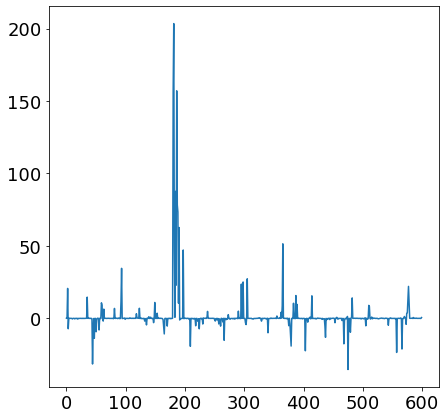

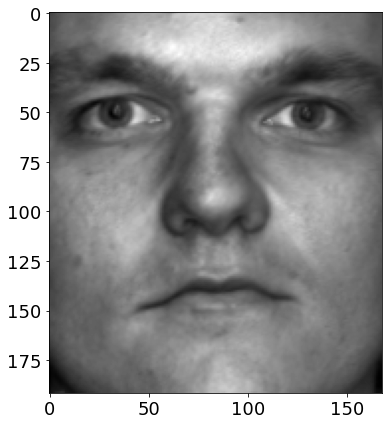

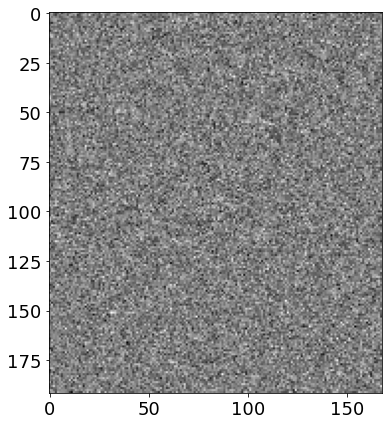

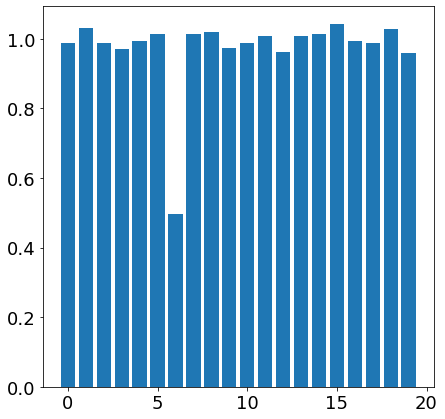

In [20]:
plt.figure()
plt.plot(s4)
plt.figure()
plt.imshow(np.reshape(Train @ (s4 / normTheta), (m, n)).T, cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4 / normTheta), (m, n)).T, cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k * nTrain, (k + 1) * nTrain)
    binErr[k] = np.linalg.norm(x4 - Train[:, L] @ (s4[L] / normTheta[L])) / np.linalg.norm(x4)

plt.figure()
plt.bar(range(nPeople), binErr)
plt.show()

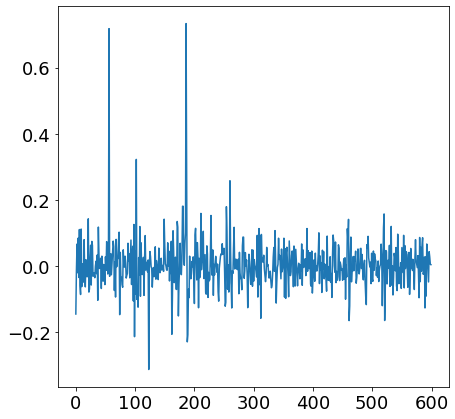

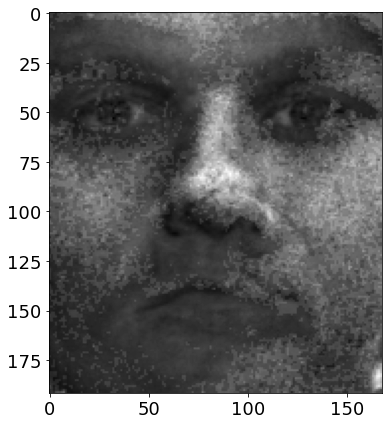

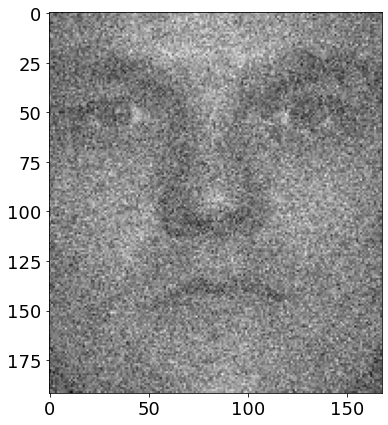

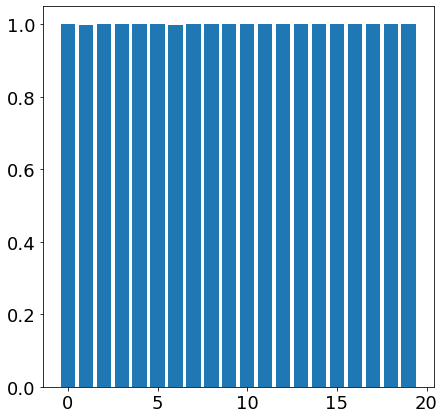

In [22]:
## Least Squares Is No Good
s4L2 = np.linalg.pinv(Train) @ x4
plt.figure()
plt.plot(s4L2)
plt.figure()
plt.imshow(np.reshape(Train @ (s4L2 / normTheta), (m, n)).T, cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4L2 / normTheta), (m, n)).T, cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k * nTrain, (k + 1) * nTrain)
    binErr[k] = np.linalg.norm(x4 - Train[:, L] @ (s4L2[L] / normTheta[L])) / np.linalg.norm(x4)

plt.figure()
plt.bar(range(nPeople), binErr)
plt.show()